In [27]:
from autograd import grad
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane import qchem

np.set_printoptions(precision=5)

symbols = ["H", "H"]
# optimized geometry at the Hartree-Fock level
geometry = np.array([[-0.672943567415407, 0.0, 0.0],
                     [ 0.672943567415407, 0.0, 0.0]], requires_grad=True)

In [28]:
mol = qml.qchem.Molecule(symbols, geometry)

In [29]:
qml.qchem.hf_energy(mol)(geometry)

array(-1.11751)

In [30]:
grad(qml.qchem.hf_energy(mol))(geometry)

array([[ 1.84661e-05,  0.00000e+00,  0.00000e+00],
       [-1.84661e-05,  0.00000e+00,  0.00000e+00]])

In [31]:
S1 = mol.basis_set[0]
S2 = mol.basis_set[1]


In [32]:
for param in S1.params:
    print(param)

[3.42525 0.62391 0.16886]
[0.27693 0.26784 0.08347]
[-0.67294  0.       0.     ]


In [33]:
S1.l

(0, 0, 0)

In [34]:
qml.qchem.overlap_integral(S1, S2)([geometry[0], geometry[1]])

tensor(0.4131, requires_grad=True)

In [35]:
grad(qml.qchem.overlap_integral(S1, S2))([geometry[0], geometry[1]])

[array([0.39219, 0.     , 0.     ]), array([-0.39219,  0.     ,  0.     ])]

In [36]:
V1 = mol.atomic_orbital(0)
V1(0.0, 0.0, 0.0)

tensor(0.33796, requires_grad=True)

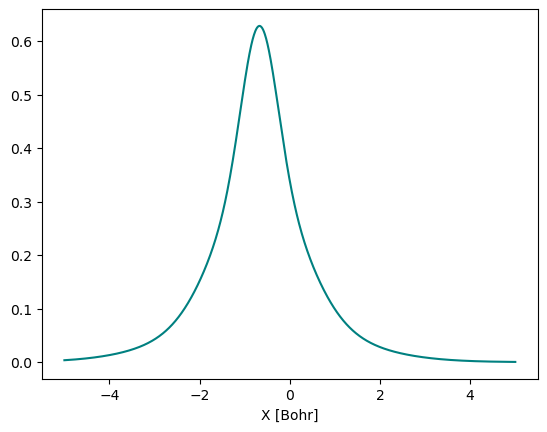

In [37]:
x = np.linspace(-5, 5, 1000)
plt.plot(x, V1(x, 0.0, 0.0), color='teal')
plt.xlabel('X [Bohr]')
plt.show()

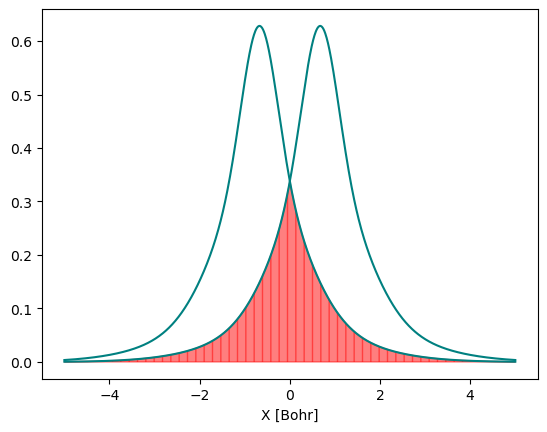

In [38]:
V2 = mol.atomic_orbital(1)
plt.plot(x, V1(x, 0.0, 0.0), color='teal')
plt.plot(x, V2(x, 0.0, 0.0), color='teal')
plt.fill_between(
    x,  np.minimum(V1(x, 0.0, 0.0), V2(x, 0.0, 0.0)), color = 'red', alpha = 0.5, hatch = '||')
plt.xlabel('X [Bohr]')
plt.show()

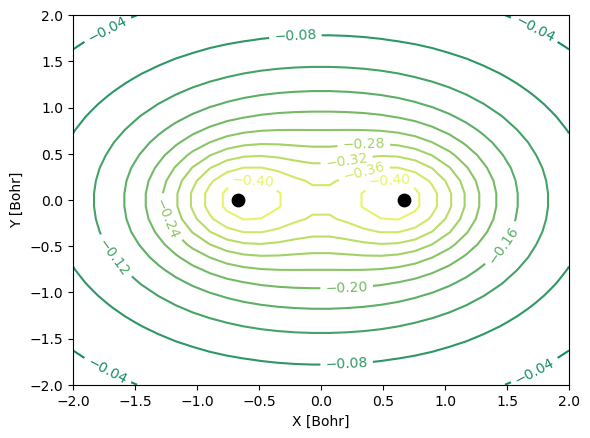

In [39]:
n = 30 # number of grid points along each axis

mol.mo_coefficients = mol.mo_coefficients.T
mo = mol.molecular_orbital(0)
x, y = np.meshgrid(np.linspace(-2, 2, n),
                   np.linspace(-2, 2, n))
val = np.vectorize(mo)(x, y, 0)
val = np.array([val[i][j]._value for i in range(n) for j in range(n)]).reshape(n, n)

fig, ax = plt.subplots()
co = ax.contour(x, y, val, 10, cmap='summer_r', zorder=0)
ax.clabel(co, inline=2, fontsize=10)
plt.scatter(mol.coordinates[:,0], mol.coordinates[:,1], s = 80, color='black')
ax.set_xlabel('X [Bohr]')
ax.set_ylabel('Y [Bohr]')
plt.show()

In [40]:
H, qubits = qml.qchem.molecular_hamiltonian(mol.symbols,
                                                      mol.coordinates,
                                                      args=[mol.coordinates])

print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is    (-0.23666488761989457) [Z3]
+ (-0.23666488761989452) [Z2]
+ (-0.0596386281746438) [I0]
+ (0.17575739479886332) [Z0]
+ (0.17575739479886335) [Z1]
+ (0.12222640951957506) [Z0 Z2]
+ (0.12222640951957506) [Z1 Z3]
+ (0.16714375519102587) [Z0 Z3]
+ (0.16714375519102587) [Z1 Z2]
+ (0.17001485407399844) [Z0 Z1]
+ (0.175702783450794) [Z2 Z3]
+ (-0.044917345671450816) [Y0 Y1 X2 X3]
+ (-0.044917345671450816) [X0 X1 Y2 Y3]
+ (0.044917345671450816) [Y0 X1 X2 Y3]
+ (0.044917345671450816) [X0 Y1 Y2 X3]


In [41]:
dev = qml.device("default.qubit", wires=qubits)
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [42]:

def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0,1,2,3])
    
@qml.qnode(dev, interface="autograd")
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)

In [43]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

theta = np.array(0.0, requires_grad=True)

In [44]:
# store the values of the cost function
energy = [cost_fn(theta)]
# store the values of the circuit parameter
angle = [theta]



max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = -1.12827797 Ha
Step = 2,  Energy = -1.13518761 Ha
Step = 4,  Energy = -1.13652737 Ha
Step = 6,  Energy = -1.13678556 Ha
Step = 8,  Energy = -1.13683526 Ha
Step = 10,  Energy = -1.13684483 Ha
Step = 12,  Energy = -1.13684667 Ha

Final value of the ground-state energy = -1.13684667 Ha

Optimal value of the circuit parameter = 0.2135


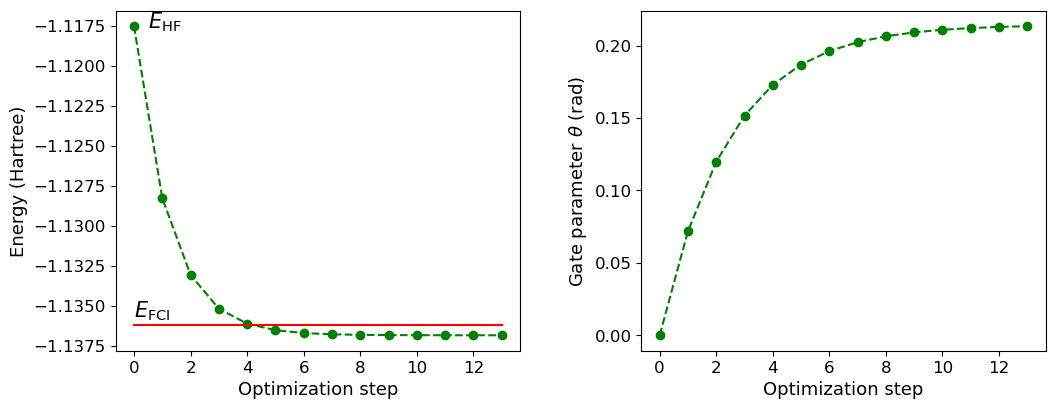

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()